In [1]:
#This kernel is going to import, sort, and classify the dataset into training, validation, and testing data

####DO NOT USE TESTING DATA UNTIL THE END OF THE SUMMER!!!####

#importing some necessary modules

import pathlib
from pathlib import Path
import kagglehub

#creating the path to the dataset, found on Kaggle
path = kagglehub.dataset_download("iarunava/cell-images-for-detecting-malaria")

###creating the path to the training and validation directories###

#importing the necessary modules
import os
import random
import shutil
from pathlib import Path

path = Path(path)

#setting seed if others want to reproduce this work
random.seed = (42)

#The Source Directory and Target Directory Paths
source_dir = path / "cell_images"
output_dir = Path("cell_data")
classes = ['Parasitized', 'Uninfected']

#split ratios (may be adjusted later)
training_split = 0.7
val_split = 0.15 #used to adjust hyperparameters
test_split = 0.15

#creating the directory structure
for split in ['train', 'val', 'test']:
  for cls in classes:
    os.makedirs(output_dir / split / cls, exist_ok=True)

#defining the function to split and copy the files
def split_and_copy(class_name):
  class_path = source_dir / class_name
  RBC_images = list(class_path.glob("*.png")) #there are .png in this database. If the code is recycled, make sure it aligns with the dataset

  #shuffling the images and then setting how many there will be in each subset
  random.shuffle(RBC_images)
  total = len(RBC_images)
  train_end = int(training_split * total)
  val_end = train_end + int(val_split*total)

  splits = {
      'train' : RBC_images[:train_end],
      'val' : RBC_images[train_end:val_end],
      'test' : RBC_images[val_end:]
  }

  for split_name, split_files in splits.items():
    for img_path in split_files:
      shutil.copy(img_path, output_dir / split_name / class_name / img_path.name)

for cls in classes:
  split_and_copy(cls)

print('Classes split and copied successfully.')


Classes split and copied successfully.


In [2]:
#This kernel is going to do the data preprocessing

import tensorflow as tf
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing import image_dataset_from_directory

#setting global variables which can be adjusted more easily
height, width = 224, 224 #optimal for EfficientNetB0, can be changed later
size_of_batch = 32
seed_number = 42

#loading and splitting the datasets
train_ds = image_dataset_from_directory(
    "cell_data/train",
    label_mode = 'binary',
    image_size = (height, width),
    batch_size = size_of_batch,
    shuffle = True,
    seed = seed_number
)

val_ds = image_dataset_from_directory(
    "cell_data/val",
    label_mode = 'binary',
    image_size = (height, width),
    batch_size = size_of_batch
)

test_ds = image_dataset_from_directory(
    "cell_data/test",
    label_mode = 'binary',
    image_size = (height, width),
    batch_size = size_of_batch
)

#normalizing the pixel data (from 0-255 to 0-1)
train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y))

#AUTOTUNE allows the GPU to run several things concurrently, speeding up the processing time
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

#This is going to 'augment' the data. Creates slight variations which are going to allow for a more robust dataset

from tensorflow.keras import layers

#mirrors, rotates, zooms, and changes image contrast
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.35),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2)
])


Found 19290 files belonging to 2 classes.
Found 4132 files belonging to 2 classes.
Found 4136 files belonging to 2 classes.


In [3]:
#this kernel will set up the initial model

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

base_model = EfficientNetB0(
    include_top=False, #this means that we'll add our own classifier head
    input_shape=(224, 224, 3), #the depth is three layers, which might be adjusted later
    weights = 'imagenet' #pretrained weights
)

base_model.trainable = False #this keeps the base layer frozen. Can update later

models = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3), #regularization
    layers.Dense(1, activation='sigmoid') #binary classification
])

models.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

models.summary()

history = models.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20 #we'll start with a small number, increase if needed later
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 84s 98ms/step - accuracy: 0.7711 - loss: 0.5148 - val_accuracy: 0.8928 - val_loss: 0.3184
Epoch 2/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 39s 49ms/step - accuracy: 0.8756 - loss: 0.3262 - val_accuracy: 0.9039 - val_loss: 0.2613
Epoch 3/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 40s 47ms/step - accuracy: 0.8936 - loss: 0.2793 - val_accuracy: 0.9136 - val_loss: 0.2355
Epoch 4/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.9054 - loss: 0.2532 - val_accuracy: 0.9182 - val_loss: 0.2189
Epoch 5/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 29s 49ms/step - accuracy: 0.9082 - loss: 0.2363 - val_accuracy: 0.9242 - val_loss: 0.2074
Epoch 6/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 34s 56ms/step - accuracy: 0.9134 - loss: 0.2262 - val_accuracy: 0.9262 - val_loss: 0.1991
Epoch 7/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 30s 49ms/step - accuracy: 0.9171 - loss: 0.2182 - val_accuracy: 0.9291 - val_loss: 0.1925
Epoch 8/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 34s 56ms/step - accuracy: 0.9203 - loss: 0.2123 - 

In [4]:
#this will display the overall projected values of training and loss

loss, accuracy = models.evaluate(val_ds)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

loss, accuracy = models.evaluate(train_ds)
print(f"Training Loss: {loss:.4f}")
print(f"Training Accuracy: {accuracy:.4f}")

130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.9424 - loss: 0.1672
Validation Loss: 0.1593
Validation Accuracy: 0.9448
603/603 ━━━━━━━━━━━━━━━━━━━━ 34s 56ms/step - accuracy: 0.9432 - loss: 0.1592
Training Loss: 0.1589
Training Accuracy: 0.9442


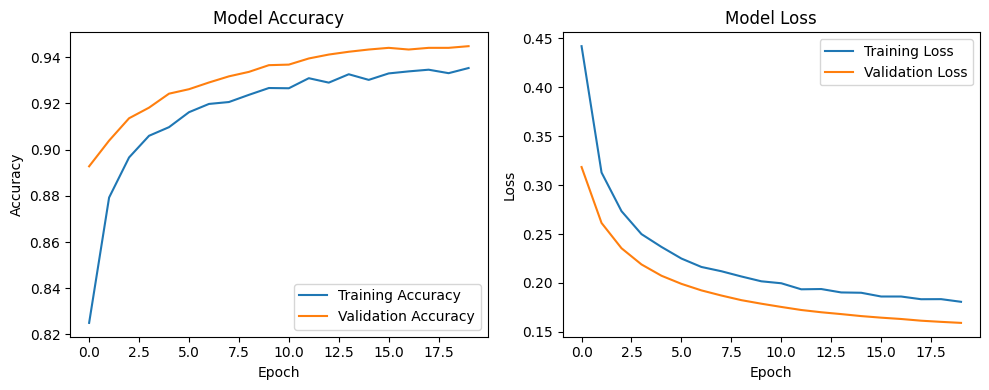

In [5]:
#getting a real-time plot of the accuracies and losses over the course of the first training batch
import matplotlib.pyplot as plt


#this is plot accuracy
plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

#plot loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
#this will give us additional statistics which are more relevant to medical diagnoses

import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

y_true = np.concatenate([y for x,y in val_ds], axis=0)
y_pred_probs = models.predict(val_ds)
y_pred = (y_pred_probs > 0.5).astype('int32').flatten()

print(classification_report(y_true, y_pred, target_names=['Parasitized', 'Uninfected']))
print('Confusion Matrix:')
print(confusion_matrix(y_true, y_pred))

130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step
              precision    recall  f1-score   support

 Parasitized       0.50      0.49      0.50      2066
  Uninfected       0.50      0.51      0.50      2066

    accuracy                           0.50      4132
   macro avg       0.50      0.50      0.50      4132
weighted avg       0.50      0.50      0.50      4132

Confusion Matrix:
[[1013 1053]
 [1013 1053]]


In [13]:
#this is going to be further training of the model, due to the low precision and recall that we found

base_model.trainable = True #this makes all the layers trainable

#freezing earlier layers to save RAM and some pretrained features
fine_tune_at = 100
for layers in base_model.layers[:fine_tune_at]:
    layers.trainable = False

models.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

#this will enable us to avoid overfitting if necessary
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=0.000001
)

history = models.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 144s 143ms/step - accuracy: 0.9762 - loss: 0.0655 - val_accuracy: 0.9688 - val_loss: 0.0890 - learning_rate: 1.0000e-05
Epoch 2/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 46s 76ms/step - accuracy: 0.9794 - loss: 0.0562 - val_accuracy: 0.9690 - val_loss: 0.0899 - learning_rate: 1.0000e-05
Epoch 3/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 47s 79ms/step - accuracy: 0.9823 - loss: 0.0516 - val_accuracy: 0.9690 - val_loss: 0.0894 - learning_rate: 1.0000e-05
Epoch 4/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 53s 88ms/step - accuracy: 0.9837 - loss: 0.0462 - val_accuracy: 0.9688 - val_loss: 0.0899 - learning_rate: 5.0000e-06


In [16]:
#this will display the overall projected values of training and loss

loss, accuracy = models.evaluate(val_ds)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

loss, accuracy = models.evaluate(train_ds)
print(f"Training Loss: {loss:.4f}")
print(f"Training Accuracy: {accuracy:.4f}")

130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9680 - loss: 0.0946
Validation Loss: 0.0890
Validation Accuracy: 0.9688
603/603 ━━━━━━━━━━━━━━━━━━━━ 30s 50ms/step - accuracy: 0.9874 - loss: 0.0359
Training Loss: 0.0352
Training Accuracy: 0.9881


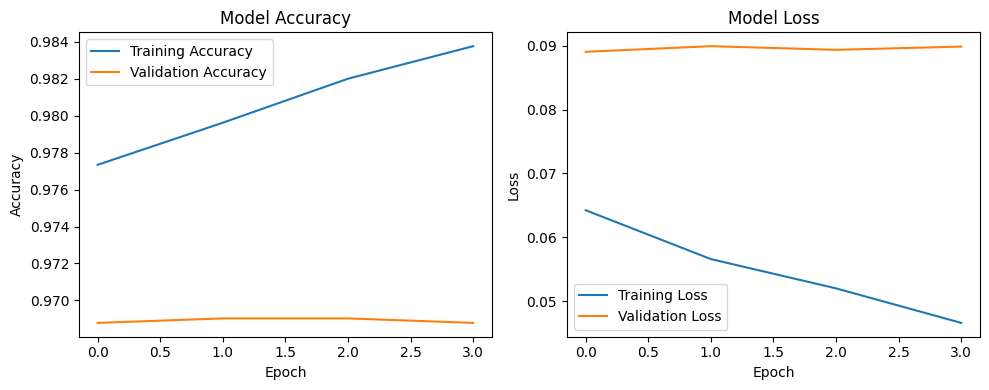

In [14]:
#getting a real-time plot of the accuracies and losses over the course of the first training batch
import matplotlib.pyplot as plt


#this is plot accuracy
plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

#plot loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
#this will give us additional statistics which are more relevant to medical diagnoses

import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Extract true labels and predictions from val_ds
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = models.predict(images)
    preds = tf.round(preds).numpy().astype(int).flatten()
    y_pred.extend(preds)
    y_true.extend(labels.numpy().astype(int).flatten())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Optional: classification report
print(classification_report(y_true, y_pred, target_names=["Uninfected", "Parasitized"]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━

In [19]:
from tensorflow.keras.applications.efficientnet import preprocess_input
import tensorflow as tf

test_dir = 'cell_data/test'

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='binary',
    image_size=(224, 224),  # same as your model input size
    batch_size=32,
    shuffle=False  # Don't shuffle — useful for confusion matrix
)

# Normalize the test data using EfficientNet preprocessing
test_ds = test_ds.map(lambda x, y: (preprocess_input(x), y))

#evaluating the model
loss, accuracy = models.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

#further statistics
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Get true labels and predictions
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_probs = models.predict(test_ds)
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()

# Confusion matrix and report
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Uninfected', 'Parasitized']))

Found 4136 files belonging to 2 classes.
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.9649 - loss: 0.0906
Test Loss: 0.0806
Test Accuracy: 0.9707
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step
Confusion Matrix:
[[1990   78]
 [  43 2025]]

Classification Report:
              precision    recall  f1-score   support

  Uninfected       0.98      0.96      0.97      2068
 Parasitized       0.96      0.98      0.97      2068

    accuracy                           0.97      4136
   macro avg       0.97      0.97      0.97      4136
weighted avg       0.97      0.97      0.97      4136



In [ ]:
#saving and exporting the model for external use
models.save('malaria_cell_model')

#making this into a .zip file
import shutil
shutil.make_archive('malaria_cell_model', 'zip', 'malaria_cell_model')

from google.colab import files
files.download('malaria_cell_model.zip')

